# Classifier experimentation
Training data should be all set, let's take a quick look for sanity and then dig into building the text classifier. Plan here is to try a bunch of different things, follow any interesting ideas or insights and see what sticks. Some thoughts to get started:

1. ~~Should we use the DMLC XGBoost package or the gradient boosting classifier included in scikit-learn?~~ Use XGBoost via the scikit-learn API, classification performance is similar to scikit-learn's gradient boosting classifier, but it's much faster.

2. ~~Binary cross entropy seems like the obvious loss function to use, but what metrics should we track?~~

    - The default for XGBoost on this type of task is '**binary:logistic**' - but I haven't found exactly what that loss function is yet...
    - For scikit-learn gradient boosting classifier the default is '**log_loss**' which, according to the documentation 'refers to binomial and multinomial deviance, the same as used in logistic regression'.

    Ok, fine - only way I see to confirm that those are the same is dig into the source code. Definitely not worth the effort. At the end of the day, exactly what/how it is optimized and if it's the same between the two frameworks does not really matter - what we need is a way to evaluate both of them.

    I like false positive and false negative rates, we can get those from the confusion matrix (and also plot that at the same time). We should probably include accuracy as a percent for the less-statistically minded. We need a third to give a good look at the underlying probabilities rather than the 'calls'. Let's go with binary cross-entropy, in scikit-learn the **log_loss**.
    
3. ~~Do some hyperparameter tuning.~~ Done.
4. ~~Make sure we can do k-fold cross validation rather than looking at the test data all the time.~~ Done.
5. ~~Is there an easy way to do early stopping?~~ Yep - it's built into the sklearn API.
6. Is there an easy way to make training plots (i.e. training & validation loss over time)?
7. What about random forest?
8. Take a look at examples we have a hard time with.
9. Take a look at feature importance.
10. Maybe throw in some other methods (i.e. deep neural network/logistic regression), just for completeness.
11. ~~Build a results data structure so we can track the winners at each stage.~~ Done.

In [1]:
# Turn sampling on or off for rapid development
sample = False

# Change working directory to parent so we can import as we would from main.py
%cd ..

import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, Trials

import configuration as config
import functions.notebook_helper as helper_funcs

/mnt/arkk/llm_detector/classifier


## 1. Training data
Let's take a look:

In [2]:
# Load the raw training data
training_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF)
testing_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF)

# Take a sample if desired:
if sample is True:
    training_data_df = training_data_df.sample(1000)

percent_human_fragments = (len(training_data_df[training_data_df['Source'] == 'human']) / len(training_data_df)) * 100
print(f'Text fragments are {percent_human_fragments}% human\n')

training_data_df.info()
print()
training_data_df.head()

Text fragments are 49.56169925826028% human

<class 'pandas.core.frame.DataFrame'>
Index: 1483 entries, 0 to 1482
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (words)                  1483 non-null   int64  
 1   Fragment length (tokens)                 1483 non-null   int64  
 2   Source                                   1483 non-null   object 
 3   String                                   1483 non-null   object 
 4   Perplexity                               1483 non-null   float64
 5   Cross-perplexity                         1483 non-null   float64
 6   Perplexity ratio score                   1483 non-null   float64
 7   Perplexity ratio Kullback-Leibler score  1483 non-null   float64
 8   Human TF-IDF                             1483 non-null   float64
 9   Synthetic TF-IDF                         1483 non-null   float64
 10  TF-IDF s

,Fragment length (words),Fragment length (tokens),Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF Kullback-Leibler score
0,359,484,human,"from the United States. But many people, inclu...",2.356540,2.448430,0.962470,0.074124,-2.705007,-2.511070,1.011594,0.030621
1,99,142,synthetic,"book, The Battle for Kapyong, which tells the ...",2.387516,3.155705,0.756571,3.171942,-2.193385,-2.257736,-0.286435,0.117439
2,105,138,human,blow up the railway goods yard which once stoo...,3.173659,3.189401,0.995064,0.169718,-3.128597,-2.321240,4.399967,0.028482
3,24,44,human,"tips and ingredient and product reviews, visit...",3.147423,3.083533,1.020720,0.244851,-2.723781,-2.388982,1.711748,0.007929
4,89,125,synthetic,"t, for instance, is one of the first third-par...",2.486056,2.808219,0.885278,1.083115,-2.516022,-2.157743,1.674515,0.008559


In [3]:
# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# Split into training and test sets
# features_train_df, features_test_df, labels_train, labels_test = train_test_split(
#     features,
#     encoded_labels,
#     test_size = 0.3,
#     random_state = 0
# )

# Keep a dataframe copy of the features for easy manipulation later and make 
# a numpy copy for training without the dataset or string columns
# features_train = features_train_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
# features_test = features_test_df.drop(['Dataset', 'String'], axis = 1).to_numpy()

# v2 data does not have a dataset column to drop.
features_train = features_train_df.drop(['String'], axis = 1).to_numpy()
features_test = features_test_df.drop(['String'], axis = 1).to_numpy()

print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(features_test)} examples')
print()
print('Training features:')
print(features_train_df.info())
print()
print('Training labels:')
print(labels_train)

Training data: 1483 examples
Test data: 1483 examples

Training features:
<class 'pandas.core.frame.DataFrame'>
Index: 1483 entries, 0 to 1482
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (words)                  1483 non-null   int64  
 1   Fragment length (tokens)                 1483 non-null   int64  
 2   String                                   1483 non-null   object 
 3   Perplexity                               1483 non-null   float64
 4   Cross-perplexity                         1483 non-null   float64
 5   Perplexity ratio score                   1483 non-null   float64
 6   Perplexity ratio Kullback-Leibler score  1483 non-null   float64
 7   Human TF-IDF                             1483 non-null   float64
 8   Synthetic TF-IDF                         1483 non-null   float64
 9   TF-IDF score                             1483 non

Let's also make a data structure to collect results for plotting as we go.

In [4]:
# Dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

## 3. Off-the-shelf classifiers

In [5]:
# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

In [6]:
# Some parameters
kfolds = 3
random_state = 23
parallel_jobs = 20

### 2.1. XGBoost XGBClassifier

In [7]:
%%time 

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'XGBC')

CPU times: user 79.9 ms, sys: 193 ms, total: 272 ms
Wall time: 2.56 s


### 2.2. scikit-learn GradientBoostingClassifier

In [8]:
%%time

# Instantiate sklearn gradient boosting classifier
model = GradientBoostingClassifier(random_state = random_state)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'GBC')

CPU times: user 20.1 ms, sys: 5.76 ms, total: 25.8 ms
Wall time: 2.67 s


### 2.3. scikit-learn HistGradientBoostingClassifier

In [9]:
%%time

from sklearn.ensemble import HistGradientBoostingClassifier

# Instantiate sklearn gradient boosting classifier
model = HistGradientBoostingClassifier(random_state = random_state)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'HGBC')

CPU times: user 20.7 ms, sys: 2.77 ms, total: 23.5 ms
Wall time: 2.71 s


### 2.4. Results

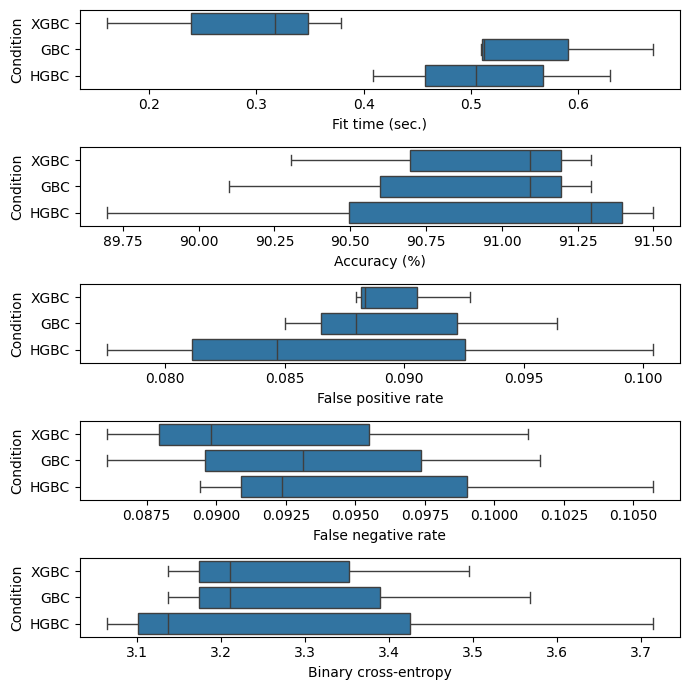

In [10]:
helper_funcs.plot_cross_validation(plots, results).show()

OK, pretty good - we are not over-fitting or just guessing the major class, we are in the mid-low 90% accuracy for all three implementation. This is actually a pretty good bump over the LLaMA2 based perplexity ratio score where we never got better than 88%. Problem now is as before, high false positive rate >= 15% for all three implementations. We may be able to mitigate that somewhat at the cost of false negatives with some threshold tuning later. First let's do some:

## 3. Hyperparameter optimization

In [11]:
# How many iterations to run
n_iter = 500

# Parameter optimization space
space = {
       'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
       'max_iter': scope.int(hp.quniform('max_iter', 10, 1000, 1)),
       'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 15, 60, 1)),
       'max_depth': scope.int(hp.quniform('max_depth', 1, 1000, 1)),
       'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 100, 1)),
       'l2_regularization': hp.uniform('l2_regularization', 0.001, 1.0)
}

### 3.1. HistGradientBoostingClassifier: single training-validation split

In [12]:
# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = 0.3,
    random_state = 0
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
       early_stopping = True,
       validation_fraction = 0.1,
       n_iter_no_change = 10, 
       random_state = random_state
)

best = fmin(
       fn = partial(
              helper_funcs.hyperopt,
              model = model,
              features_training = optimization_features_training, 
              labels_training = optimization_labels_training,
              features_validation = optimization_features_validation, 
              labels_validation = optimization_labels_validation
       ),
       space = space,       # Parameter: value dictionary
       algo = tpe.suggest,  # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,  # Maximum number of iterations
       trials = trials      # Logging
)

100%|██████████| 500/500 [01:34<00:00,  5.32trial/s, best loss: 3.0778850085088805]


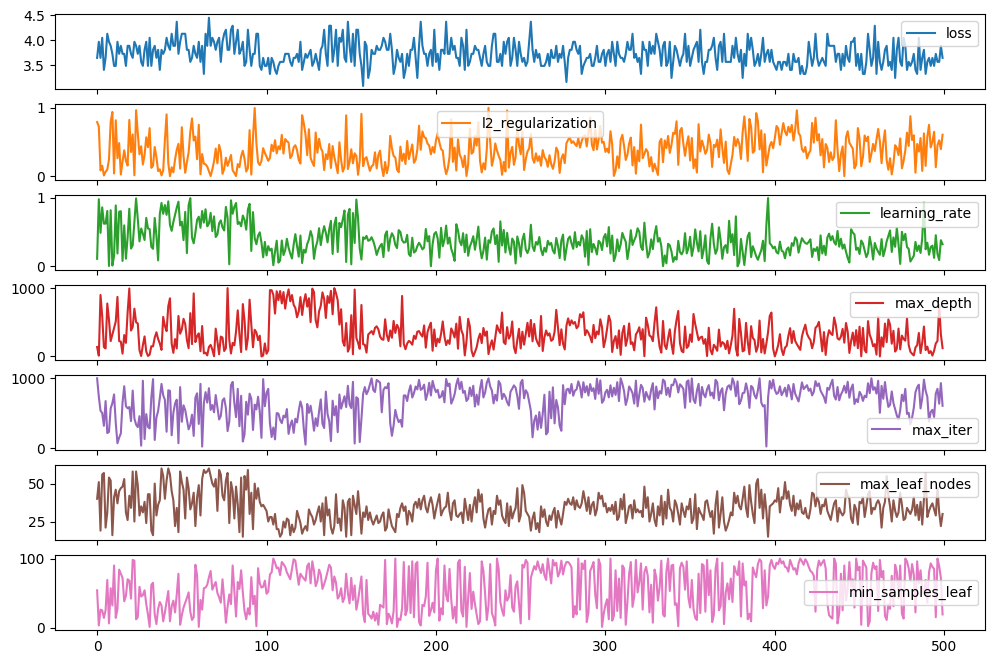

In [13]:
optimization_plot = helper_funcs.make_optimization_plot(trials.trials)

In [14]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = best['learning_rate'],
    max_iter = int(best['max_iter']),
    max_leaf_nodes = int(best['max_leaf_nodes']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    l2_regularization = best['l2_regularization'],
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10, 
    random_state = random_state
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized HGBC')


Optimized parameters:

 l2_regularization: 0.1474252322345308
 learning_rate: 0.4251198805728065
 max_depth: 179.0
 max_iter: 776.0
 max_leaf_nodes: 31.0
 min_samples_leaf: 20.0



### 3.2. HistGradientBoostingClassifier with k-fold cross validation

In [15]:
# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
       early_stopping = True,
       validation_fraction = 0.1,
       n_iter_no_change = 10, 
       random_state = random_state
)

# Set up trial logging
trials_cv = Trials()

best_cv = fmin(
       fn = partial(
              helper_funcs.hyperopt_cv,
              model = model,
              features = features_train, 
              labels = labels_train
       ),
       space = space,           # Parameter: value dictionary
       algo = tpe.suggest,      # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,      # Maximum number of iterations
       trials = trials_cv       # Logging
)

100%|██████████| 500/500 [16:11<00:00,  1.94s/trial, best loss: 3.0595759759453025]


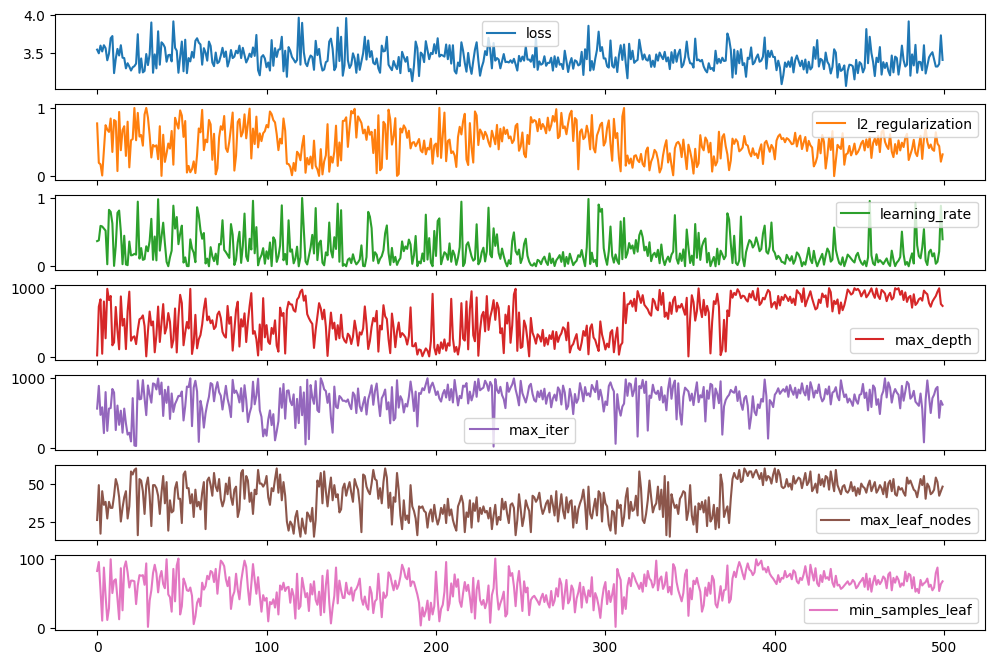

In [16]:
optimization_plot = helper_funcs.make_optimization_plot(trials_cv.trials)

In [17]:
print('Optimized parameters:\n')

for key, value in best_cv.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = best_cv['learning_rate'],
    max_iter = int(best_cv['max_iter']),
    max_leaf_nodes = int(best_cv['max_leaf_nodes']),
    max_depth = int(best_cv['max_depth']),
    min_samples_leaf = int(best_cv['min_samples_leaf']),
    l2_regularization = best_cv['l2_regularization'],
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10, 
    random_state = random_state
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'CV Optimized HGBC')

Optimized parameters:

 l2_regularization: 0.32065504807533224
 learning_rate: 0.08103731949457704
 max_depth: 856.0
 max_iter: 768.0
 max_leaf_nodes: 45.0
 min_samples_leaf: 64.0



### 3.3. XGBClassifier: single training-validation split

In [18]:
# Parameter optimization space
space = {
       'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
       'gamma': hp.uniform('gamma', 0.0, 10.0),
       'max_depth': scope.int(hp.quniform('max_depth', 1, 100, 1)),
       'min_child_weight': hp.uniform('min_child_weight', 0.0, 10.0),
       'subsample': hp.uniform('subsample', 0.5, 1.0),
       'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
       'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
       'n_estimators': scope.int(hp.quniform('n_estimators', 1, 100, 1)),
       'num_parallel_tree': scope.int(hp.quniform('num_parallel_tree', 1, 10, 1))
}

# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = 0.3,
    random_state = 0
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = XGBClassifier()

best = fmin(
       fn = partial(
              helper_funcs.hyperopt,
              model = model,
              features_training = optimization_features_training, 
              labels_training = optimization_labels_training,
              features_validation = optimization_features_validation, 
              labels_validation = optimization_labels_validation
       ),
       space = space,       # Parameter: value dictionary
       algo = tpe.suggest,  # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,  # Maximum number of iterations
       trials = trials      # Logging
)

 18%|█▊        | 92/500 [23:54<2:08:13, 18.86s/trial, best loss: 3.0778850085088805]

In [ ]:
optimization_plot = helper_funcs.make_optimization_plot(trials.trials)

In [ ]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = XGBClassifier(
    learning_rate = best['learning_rate'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    reg_alpha = best['reg_alpha'],
    reg_lambda = int(best['reg_lambda']),
    n_estimators = int(best['num_parallel_tree'])
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized XGBC')


### 3.4. Results

In [ ]:
helper_funcs.plot_cross_validation(plots, results).show()

## 4. Mis-classified examples

At this point, it feels like we have hit the limit of what the classifier is capable of. Doesn't seem like we will be able to get past 95% accuracy or below ~15% false positive rate without changing/improving features and/or data. Let's take a look at the text fragments which are bing miss-classified and see if anything jumps out.

The current winner (based on binary cross-entropy) is the optimized scikit-learn **HistGradientBoostingClassifier** - so let's train one up to play with.

In [ ]:
# Optimized parameters:

optimized_params = {
    'l2_regularization': 0.25139838576373374,
    'learning_rate': 0.03827830315392269,
    'max_depth': 795,
    'max_iter': 792,
    'max_leaf_nodes': 16,
    'min_samples_leaf': 48
}

# Instantiate and train model
model = HistGradientBoostingClassifier(random_state = random_state, **optimized_params)
model.fit(features_train, labels_train)

# Make predictions for text examples
predictions = model.predict(features_test)

In [ ]:
# Find the indices of mis-classified examples
test_error_indices = []
i = 0
n = 1

for features, label, prediction in zip(features_test, labels_test, predictions):
    if label != prediction:
        test_error_indices.append(i)

    n += 1
    i += 1

print(f'\nHave {len(test_error_indices)} ({round((len(test_error_indices) / len(predictions)) * 100, 1)}%) miss-classed text fragments from the test set')

In [ ]:
# Recover the miss-classed fragments
errors = []
test_strings = list(features_test_df['String'])

for i in test_error_indices:
    errors.append(test_strings[i])

for error in errors[:10]:
    print(f'{error}\n\n')

Hmm, hard to draw any easy conclusions why these are being miss-classified. Some are short or very low entropy, but many are not. Maybe let's look at our features' distributions in the correctly and incorrectly classed fragments.

In [ ]:
errors = features_test_df.iloc[test_error_indices]
ax = errors.plot.hist(bins=100, alpha=0.5, density=True, log=True)

In [ ]:
ax = features_test_df.plot.hist(bins=100, alpha=0.5, density=True, log=True)

Yeah, nothing jumps right out at me... Maybe let's just do some general feature checking.

## 5. Feature cross-correlation

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(features_test_df.drop(['String', 'Dataset'], axis = 1).corr())
plt.xticks(range(features_test_df.select_dtypes(['number']).shape[1]), features_test_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(features_test_df.select_dtypes(['number']).shape[1]), features_test_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

OK, so we do have some strongly correlated and anti-correlated features. Let's try just removing some of them and see if things improve.

In [ ]:
features_train_df.head()

In [ ]:
drops = ['Dataset', 'String']#, 'Perplexity', 'Human TF-IDF', 'Perplexity ratio score', 'TF-IDF score', 'Synthetic TF-IDF', 'Cross-perplexity']

trimmed_features_train_df = features_train_df.drop(drops, axis = 1)
trimmed_features_test_df = features_test_df.drop(drops, axis = 1)

f = plt.figure(figsize=(19, 15))
plt.matshow(trimmed_features_test_df.corr())
plt.xticks(range(trimmed_features_test_df.select_dtypes(['number']).shape[1]), trimmed_features_test_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(trimmed_features_test_df.select_dtypes(['number']).shape[1]), trimmed_features_test_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
# Fit model on training data
model = GradientBoostingClassifier()
model.fit(trimmed_features_train_df, labels_train)

# Make predictions for test data
y_pred = model.predict(trimmed_features_test_df)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))

Eh, dropping features doesn't make things convincingly better. Let's try some crack-head stuff, "y'all got any more of them features?"

## 6. Synthetic features

In [ ]:
features = ['Perplexity', 'Cross-perplexity', 'Perplexity ratio score', 'Perplexity ratio Kullback-Leibler score', 'Human TF-IDF', 'Synthetic TF-IDF', 'TF-IDF score', 'TF-IDF Kullback-Leibler score']

for feature in features:
    synthetic_feature = f'{feature} squared'
    training_data_df[synthetic_feature] = training_data_df[feature] ** 2

training_data_df.head()

In [ ]:
# Split the data into features and labels
labels = training_data_df['Source']
features = training_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels)
encoded_labels = label_encoder.transform(labels)
print(f'Labels: {list(zip(labels[:10], encoded_labels[:10]))}')

# Split into training and test sets
features_train_df, features_test_df, labels_train, labels_test = train_test_split(features, encoded_labels, test_size = 0.3, random_state = 0)

# Keep dataframe copy for easy manipulation later and make a numpy copy for training
# without the dataset or string columns
features_train = features_train_df.drop(['Dataset', 'String'], axis = 1).to_numpy()
features_test = features_test_df.drop(['Dataset', 'String'], axis = 1).to_numpy()

print()
print(features_train_df.head())

In [ ]:
# Fit model on training data
model = GradientBoostingClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))

OK, apparently sklearn has this built in...

In [ ]:
# demonstrate the types of features created
from sklearn.preprocessing import PolynomialFeatures

# Get rid of nan
features.dropna(axis = 1, inplace = True)

# perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree = 3)
poly_features = trans.fit_transform(features.drop(['Dataset', 'String'], axis = 1))

# Split into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(poly_features, encoded_labels, test_size = 0.3, random_state = 0)

In [ ]:
# Fit model on training data
model = GradientBoostingClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))

Nope, OK, need to move on here. Looks like there is no easy way to improve without changes to the data pipeline... We can revisit this later.